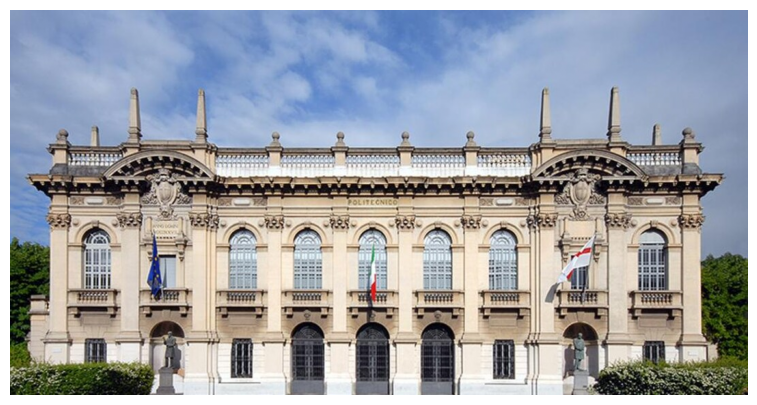

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

image_path = './polimi_compress.jpg'
img = imread(image_path)
img_RGB = [np.array(img[:,:,i], dtype = np.float64)/255 for i in range(3)]

def plot_image(RGB, ax = None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize = (12,5))
    ax.imshow(np.clip(np.stack(RGB, axis = -1),0,1))
    plt.axis('off')

plot_image(img_RGB)

In [17]:
damage_fraction = 0.7
np.random.seed(0)
mask_remove = np.random.choice(a=[True, False], size=(img.shape[0],img.shape[1]), p=[damage_fraction, 1-damage_fraction])
mask_keep = np.logical_not(mask_remove)
img_damaged_RGB = [img_RGB[i].copy() for i in range(3)]
for i in range(3):
    img_damaged_RGB[i][mask_remove] = np.random.rand(np.sum(mask_remove))

1. Display the damaged image.

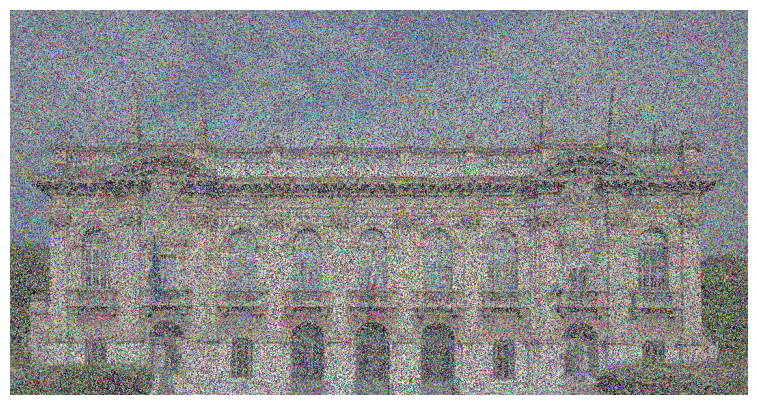

In [18]:
plot_image(img_damaged_RGB)

2. Implement the singular value truncation (SVT) algorithm to reconstruct the picture from img damaged RGB.
(Hint: apply the algorithm independently to each channel.)

In [19]:
from scipy.stats import pearsonr

def SVT(img_damaged, img_original, n_max_iter=20, threshold=100.0, increment_tol=1e-6): #note: n_max_iteration should be big (100+) but it take too much time to iterate otherwise
    RMSE_list = list()
    rho_list = list()
    
    A = img_damaged.copy()
    
    for i in range(n_max_iter):
        A_old = A.copy()
        U,s,VT = np.linalg.svd(A, full_matrices = False)
    
        s[s < threshold] = 0
        A = U @ np.diag(s) @ VT
    
        A[mask_keep] = img_original[mask_keep]
        increment = np.linalg.norm(A - A_old)
    
        vals_predicted = A[mask_remove]
        errors = img_original[mask_remove] - vals_predicted
    
        RMSE_list.append(np.sqrt(np.mean(errors**2)))
        rho_list.append(pearsonr(img_original[mask_remove],vals_predicted)[0])
    
        # print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
        # print('RMSE: %1.3f' % RMSE_list[-1])
        # print('rho:  %1.3f' % rho_list[-1])
        if increment < increment_tol:
            break
    return A, RMSE_list, rho_list

def SVT_RGB(img_damaged, img_original, threshold=100.0):
    reconstruction = []
    rmse = {}
    rho = {}
    
    r, rmse_list, rho_list = SVT(img_damaged_RGB[0], img_RGB[0], threshold=threshold)
    reconstruction.append(r)
    rmse['r'] = rmse_list
    rho['r'] = rho_list
    
    r, rmse_list, rho_list = SVT(img_damaged_RGB[1], img_RGB[1], threshold=threshold)
    reconstruction.append(r)
    rmse['g'] = rmse_list
    rho['g'] = rho_list

    r, rmse_list, rho_list = SVT(img_damaged_RGB[2], img_RGB[2], threshold=threshold)
    reconstruction.append(r)
    rmse['b'] = rmse_list
    rho['b'] = rho_list

    return reconstruction, rmse, rho


3. Try to optimize by trial and error the threshold on the singular values. Run the algorithm for 20 iterations
and plot the resulting image against the original and the damaged one.

/tmp/ipykernel_429922/2044667896.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_list.append(pearsonr(img_original[mask_remove],vals_predicted)[0])




__BEST RHO: 0.9147257780788038 OBTAINED FOR threshold = 12 __


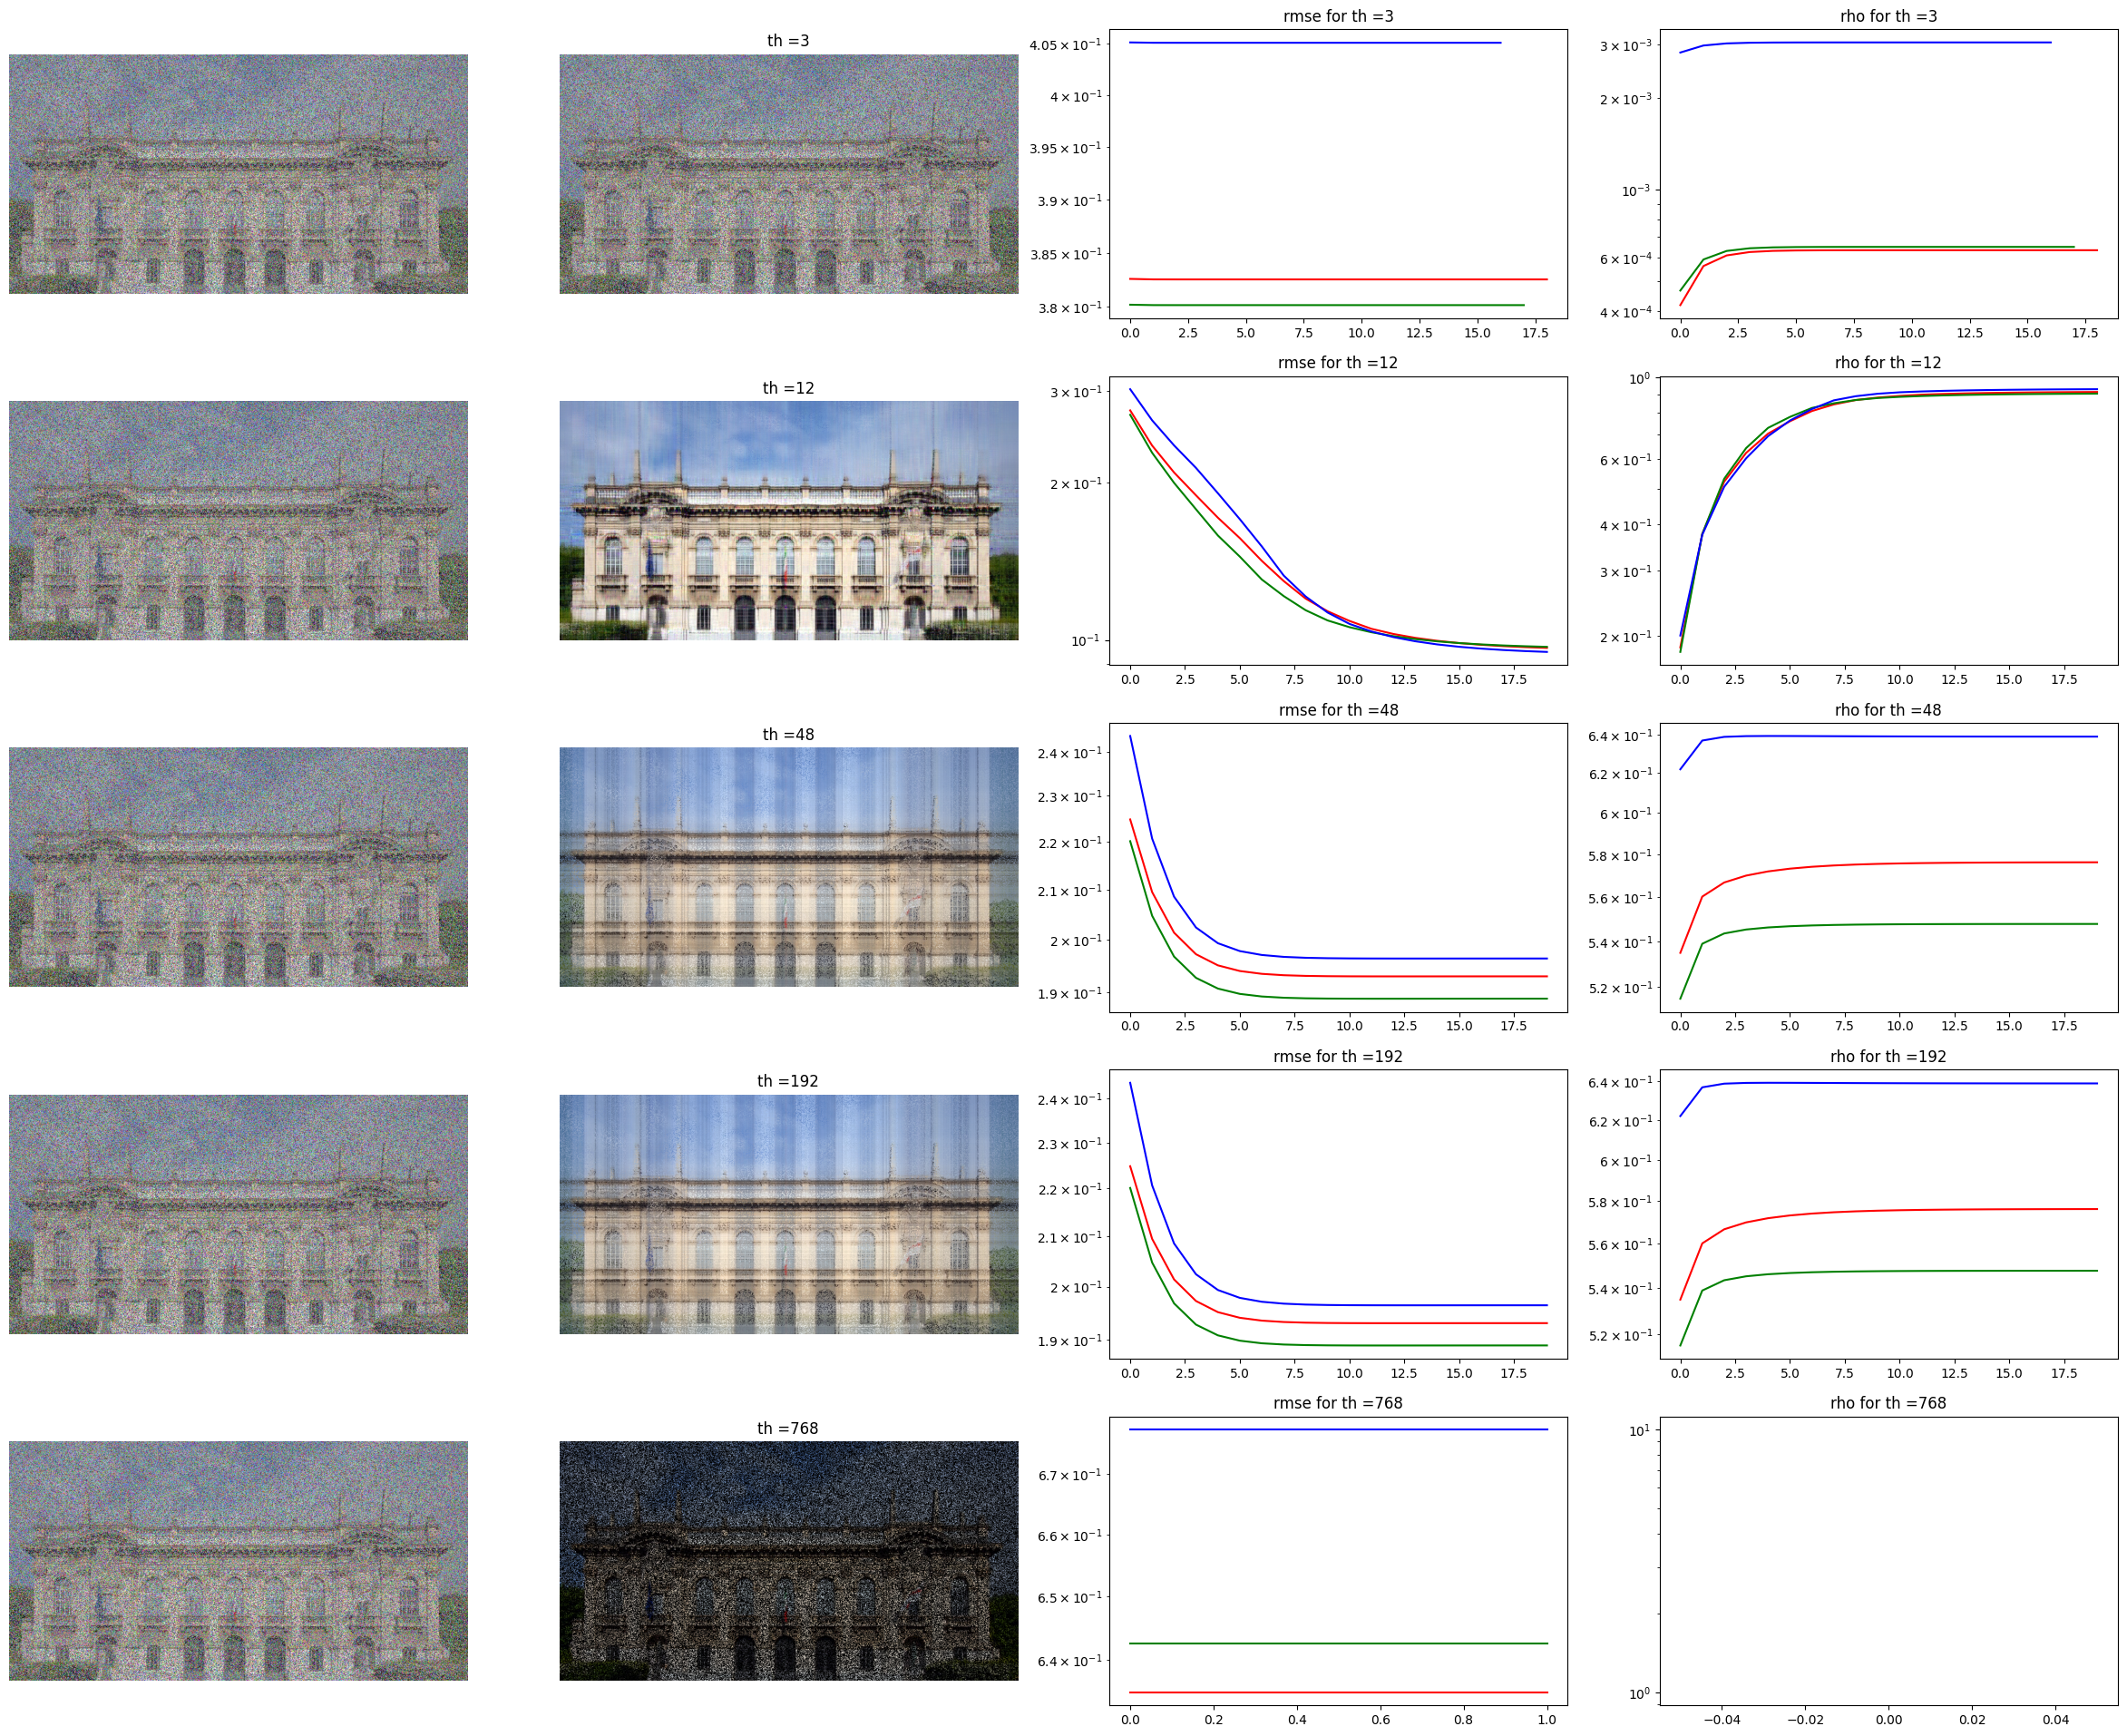

In [20]:
starting_threshold = 3
iteration_num = 5
iteration = 0
def plot_pretty(axs, iteration, img_damaged_RGB, r, rmse, rho, th):
    axs[iteration][0].imshow(np.clip(np.stack(img_damaged_RGB, axis = -1),0,1))
    axs[iteration][1].imshow(np.clip(np.stack(r, axis = -1),0,1))
    axs[iteration][1].set_title(f'th ={th}')
    axs[iteration][0].axis('off')
    axs[iteration][1].axis('off')
    
    for el in rmse:
        if len(rmse[el])==1:
            rmse[el] += rmse[el]
    axs[iteration][2].semilogy(rmse['r'], color='red')
    axs[iteration][2].semilogy(rmse['g'], color='green')
    axs[iteration][2].semilogy(rmse['b'], color='blue')
    axs[iteration][2].set_title(f'rmse for th ={th}')
    for el in rho:
        if len(rho[el])==1:
            rho[el] += rho[el]
    axs[iteration][3].semilogy(rho['r'], color='red')
    axs[iteration][3].semilogy(rho['g'], color='green')
    axs[iteration][3].semilogy(rho['b'], color='blue')
    axs[iteration][3].set_title(f'rho for th ={th}')

fig, axs = plt.subplots(nrows=iteration_num, ncols=4, figsize=(30,24))


cur_threshold = starting_threshold
best_k = -1
best_rho = 0

for i in range(0, iteration_num):
    r, rmse, rho = SVT_RGB(img_damaged_RGB, img_RGB, threshold=cur_threshold)
    plot_pretty(axs, i, img_damaged_RGB, r, rmse, rho, cur_threshold)
    if best_k == -1:
        best_k = cur_threshold
        best_rho = (rho['g'][-1] + rho['r'][-1] + rho['b'][-1])/3
    elif best_rho < (rho['g'][-1] + rho['r'][-1] + rho['b'][-1])/3:
        if not(math.isnan(rho['g'][-1])) and not(math.isnan(rho['r'][-1])) and not(math.isnan(rho['b'][-1])): 
            best_k = cur_threshold
            best_rho = (rho['g'][-1] + rho['r'][-1] + rho['b'][-1])/3
    cur_threshold *= 4

print('\n\n__BEST RHO:', best_rho, 'OBTAINED FOR threshold =', best_k, '__')
    

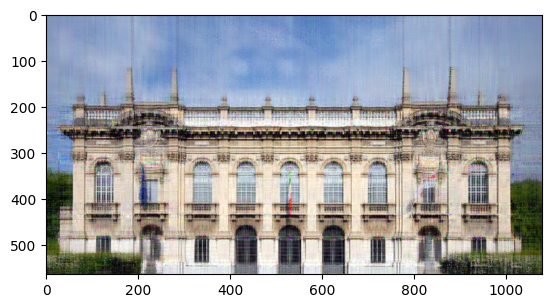

In [21]:
r, rmse, rho = SVT_RGB(img_damaged_RGB, img_RGB, threshold=12)
plt.imshow(np.clip(np.stack(r, axis = -1),0,1))

## Exercise 2
Explain how a perceptron works and how to apply the gradient descent method to optimize the parameters
of the perceptron.
Consider the following set of data

        x1 = (2, −1),y1 = 1,
        x2 = (−1, 1),y2 = 0,
        x3 = (2, 0.5),y3 = 1,
        x4 = (0.2, −0.2),y4 = 0,
        x5 = (0.5, −1),y5 = 1,
        x6 = (2, 1),y6 = 0.

How a perceptron work and how to apply gradient descent:

> The perceptron is the building block of a neural network and can be viewed as the simplest example of it.
> In particular a perceptron works as follow:
> 1. it takes an arbitrary number of values as input. So each sample is a vector of real numbers.
> 2. computes a linear combination of the values in the input. This output is formalized as: z = W@X + b
> 3. The computed linear combination is used as the input of an activation function. The result a(z) is the output of the perceptron
>
> Due to his characteristic the perceptron can be employed in order to compute binary classification with a simple iperplane as the surface responsible to discriminate the output.
>
> The application of the gradient descent method is trivial:
> for each epoch:
> - for each given input:
>   - compute forward output with the current weight and biases as:   y_pred = a(W@X + b)
>   - compute the loss as:  loss = sqrt((y - y_pred)^2)
>   - update the weights as:   W += η * d(loss)/dW
>   - update the bias as: b += η * d(loss)/db
> In the end the algorithm should have found an iperplane that accordingly classify the data

• Construct a possible separating hyperplane by hand. Express the parameters of the hyperplane in terms
of the three parameters of the perceptron.

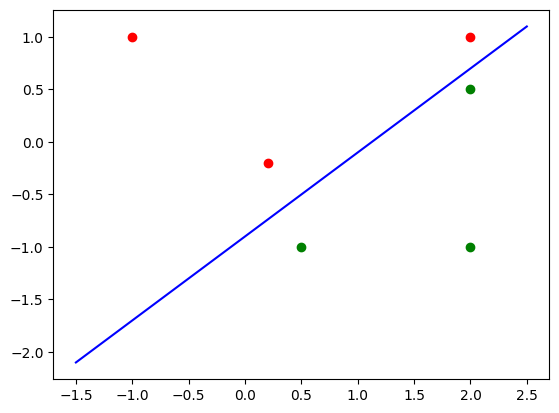

In [22]:
x = [(2,-1), (-1, 1), (2, 0.5), (0.2, -0.2), (0.5, -1), (2, 1)]
y = [1, 0, 1, 0, 1, 0]
x1_true = []
x2_true = []
x1_false = []
x2_false = []

for i in range(len(x)):
    if y[i]:
        x1_true.append(x[i][0])
        x2_true.append(x[i][1])
    else:
        x1_false.append(x[i][0])
        x2_false.append(x[i][1])


plt.scatter(x1_true, x2_true, c='green')
plt.scatter(x1_false, x2_false, c='red')

def iperplane(x1):
    return 0.8*x1 - 0.9

x_range = np.linspace(-1.5, 2.5, 100)
plt.plot(x_range, iperplane(x_range), color='blue')
plt.plot()
plt.show()

An equivalent hyperplane could be obtained from the perceptron when:
 - W = [0.8, 0] 
 - b = -0.9
 - activation function is 1 if WX+b>0, 0 otherwise (in order to perform classification)

• Implement and apply the perceptron algorithm using w0 = (1, 0) and b0 = 0. Consider a learning rate
η = 2. Draw on a figure the obtained hyperplane along with the data.

• Apply again the algorithm with η = 0.5. Draw on a figure the obtained hyperplane along with the data.

0 loss found in  6  iterations
loss =  0.0


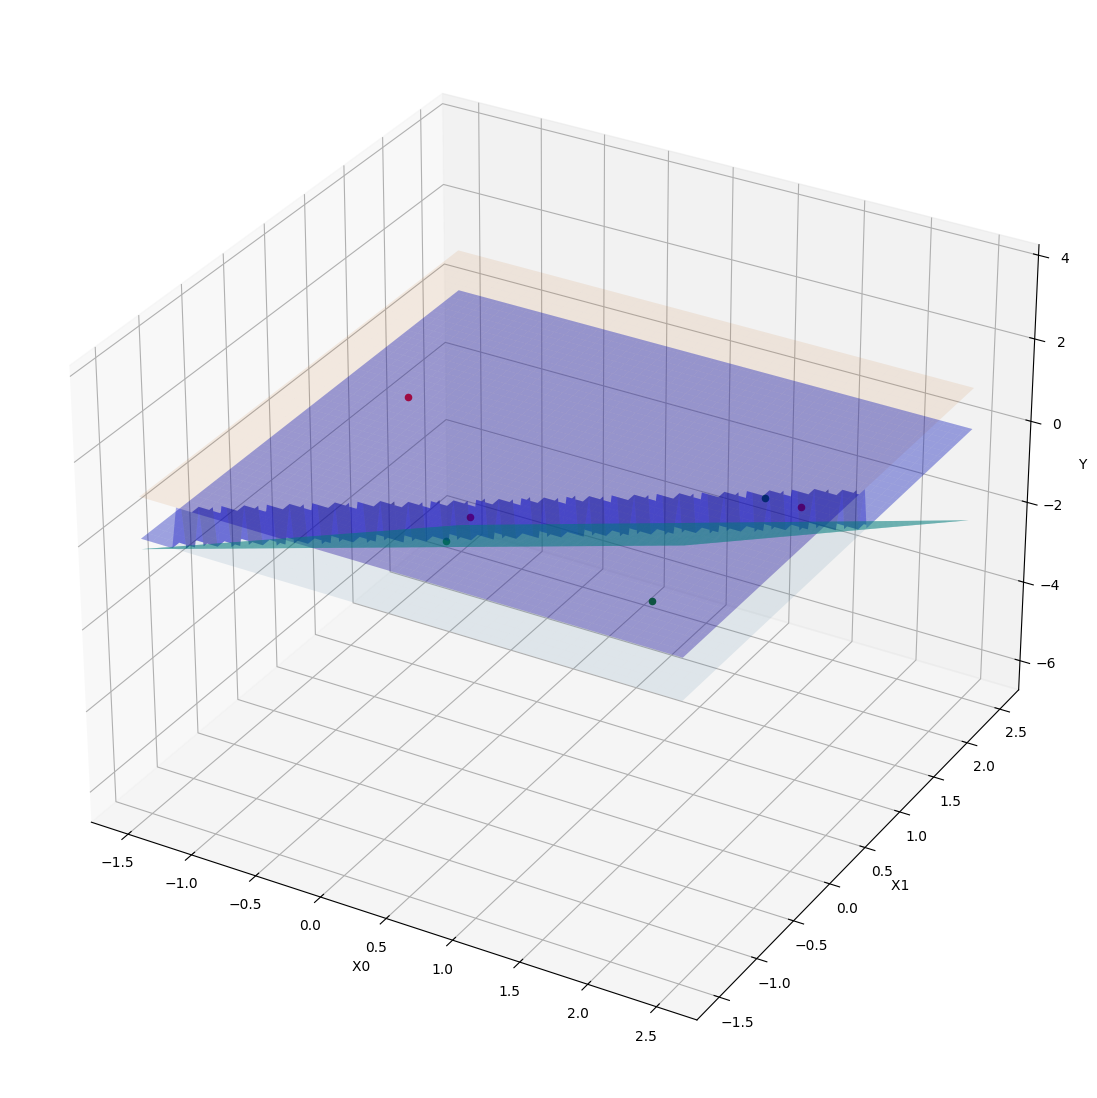

In [23]:
import jax
import jax.numpy as jnp

X = np.array([[2,-1], [-1, 1], [2, 0.5], [0.2, -0.2], [0.5, -1], [2, 1]])
Y = np.array([1, 0, 1, 0, 1, 0])

W = np.array([1., 0.])
b = np.array([0.])
# print(np.matmul(np.array([1, 2]), np.array([[1, 0],[0, 1], [3,5]])))
def perceptron(x, w, b) -> float:
    return x[0]*w[0] + x[1]*w[1] + b


def train(x, y, w, b, eta, epochs=5000):
    for epoch in range(epochs):
        miss_classification = 0.
        
        for i in range(len(y)):
            y_pred = 1 if perceptron(x[i], w, b)>0 else 0
            w[0] += eta * (y[i] - y_pred)*x[i][0]
            w[1] += eta * (y[i] - y_pred)*x[i][1]
            b += eta * (y[i] - y_pred)
            
            miss_classification += abs(y_pred - y[i])

        if miss_classification == 0:
            print('0 loss found in ', epoch, ' iterations')
            break
    print('loss = ', miss_classification)
    return w, b

eta = 0.5
trained_W, trained_b = train(X, Y, W, b, eta)

fig = plt.figure(figsize =(14, 14))
ax = plt.axes(projection ='3d')

        
def class_perceptron(x, w, b) -> float:
    val = perceptron(x, w, b)[0]
    if val > 0:
        val = 1
    elif val < 0:
        val = 0
    return np.array([val])

x_0, x_1 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.5, 100))
out = np.array([perceptron(np.array([x,y]), trained_W, trained_b) for x,y in zip(np.ravel(x_0),np.ravel(x_1))])
out = out.reshape(x_0.shape)

out2 = np.array([class_perceptron(np.array([x,y]), trained_W, trained_b) for x,y in zip(np.ravel(x_0),np.ravel(x_1))])
out2 = out2.reshape(x_0.shape)

ax.set_xlabel('X0 ')
ax.set_ylabel('X1 ')
ax.set_zlabel('Y ')


ax.plot_surface(x_0, x_1, out, alpha=0.7, color='c')
ax.plot_surface(x_0, x_1, np.zeros((1, len(x_0))), alpha=0.1)
ax.plot_surface(x_0, x_1, np.ones((1, len(x_0))), alpha=0.1)
ax.plot_surface(x_0, x_1, out2, alpha=0.3, color='blue')

for i in range(len(Y)):
    if Y[i] == 0:
        ax.scatter(X[i,0], X[i,1], Y[i], c='red', alpha=1)
    else:
        ax.scatter(X[i,0], X[i,1], Y[i], c='green')

plt.show()


Is it possible to represent in 2D the division between the two areas.

The representation will be on the x0 - x1 plane.

The discriminatory line is \begin{equation} x1 = -\frac{w_0}{w_1} x_0 - \frac{b}{w_0} \end{equation}

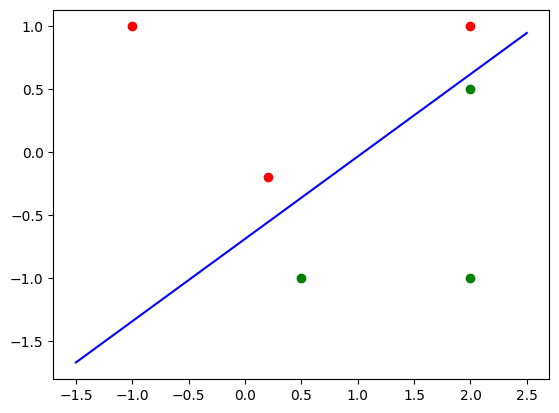

In [24]:
def get_line(x0, w, b):
    return -w[0]/w[1] * x0 - b/w[1]

x_range = np.linspace(-1.5, 2.5, 100)
plt.scatter(x1_true, x2_true, c='green')
plt.scatter(x1_false, x2_false, c='red')
plt.plot(x_range, get_line(x_range, trained_W, trained_b), color='blue')
plt.plot()
plt.show()

## Exercise 3

Suppose that the output ŷk of a given unit in a neural network is given by the softmax function i.e.:

\begin{equation} \hat{y}_k = \frac{\exp(a_k)}{\sum_{j} \exp(a_j)} \end{equation}

• Show that the output of the softmax function does not change if you shift, in all components, the activations
aj by some constant c.

> \begin{equation} \frac{\exp(a_k + c)}{\sum_{j} \exp(a_j + c)} = \frac{\exp(a_k) \cdotp \exp(a_k)}{\sum_{j} \exp(a_j} \cdotp \exp(c) =  \frac{\exp(c) \cdotp \exp(a_k)}{\exp(c) \cdotp \sum_{j} \exp(a_j)} = \frac{\exp(a_k)}{\sum_{j} \exp(a_j)} = \hat{y}_k \end{equation}


• Explain why the shift \begin{equation} c = −\max_j(a_j) \end{equation} can be useful.

> the shift may be useful because for two main reasons:
> 1 Having smaller values improves numerical stability so the formula is more reliable with respect to minor changes in the input.
> 2 Having smaller values avoid the problem of possible overflow when dealing with really large parameters for the exponential. In fact by subtracting the max, we ensures that the single exponentials term are included in the interval (0,1)